In [2]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree



import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

%cd /Users/dahala/GitHub/VAE-enzymes/
from custom_functions import *
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/



/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


In [3]:
CONFIGURATION_FILE = "msaEnzymeMiner_TRPase_trim_400_600.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/EnzymeMiner_TRPase_trim_400_600/config/2025-03-28_14-10.json
 Working with msaEnzymeMiner_TRPase_trim_400_600.json configuration file!


In [4]:
'''
HMMbuild = HMMmodule(run)
#HMMbuild.MSA_create()
HMMbuild.build()
HMMbuild.align('Trim_400_600',fasta_ext='fasta')
'''

"\nHMMbuild = HMMmodule(run)\n#HMMbuild.MSA_create()\nHMMbuild.build()\nHMMbuild.align('Trim_400_600',fasta_ext='fasta')\n"

In [31]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()

MSA in ../datasets/EnzymeMiner_TRPase_trim_400_600_fix.afa loaded
number of sequences: 5852
Trimmed MSA has 5852 sequences and the width is 455
Trimmed MSA is stored at ../results/EnzymeMiner_TRPase_trim_400_600/msa/trimmed_msa.fasta
Training MSA has 5852 sequences and the width is 455
Training MSA is stored at ../results/EnzymeMiner_TRPase_trim_400_600/msa/training_msa.fasta


In [5]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [6]:

load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

In [7]:
arch_POI=['RMG28746.1','RLE90674.1']
euka_POI=['XP_015776371.1','BAN40838.1',
     'ORY78773.1','PRD32036.1','RBR22522.1',
     'WP_071313236.1',]
bact_POI=['WP_019211973.1','AAB24234.1','WP_108870457.1',
     'WP_104148942.1','WP_129037438.1','WP_101260018.1',
     'WP_092012008.1','WP_109407456.1','WP_012992776.1',
     'WP_131680130.1','WP_001295247.1','C3LUI5_S1']

POI=['WP_104148942.1','WP_129037438.1']

In [8]:
exp_res = pd.read_csv('../../random_data/TRPase/Cleaned_Experimental_Data.csv')

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

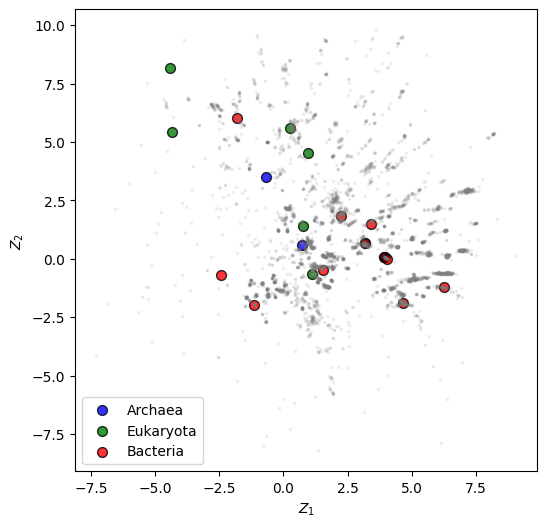

In [9]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


#query_coords = latent_space.key_to_embedding(run.fixed_sequences)
arch_coords = latent_space.key_to_embedding(arch_POI)
euka_coords = latent_space.key_to_embedding(euka_POI)
bact_coords = latent_space.key_to_embedding(bact_POI)

POI_coords = latent_space.key_to_embedding(POI)

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey')
ax.scatter(arch_coords[0::2], arch_coords[1::2], color='blue',edgecolor='black',s=50,alpha=0.8,label='Archaea')
ax.scatter(euka_coords[0::2], euka_coords[1::2], color='green',edgecolor='black',s=50,alpha=0.8,label='Eukaryota')
ax.scatter(bact_coords[0::2], bact_coords[1::2], color='red',edgecolor='black',s=50,alpha=0.8,label='Bacteria')

ax.scatter(POI_coords[0::2], POI_coords[1::2], color='black',edgecolor='black',s=50,alpha=0.5)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)


if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


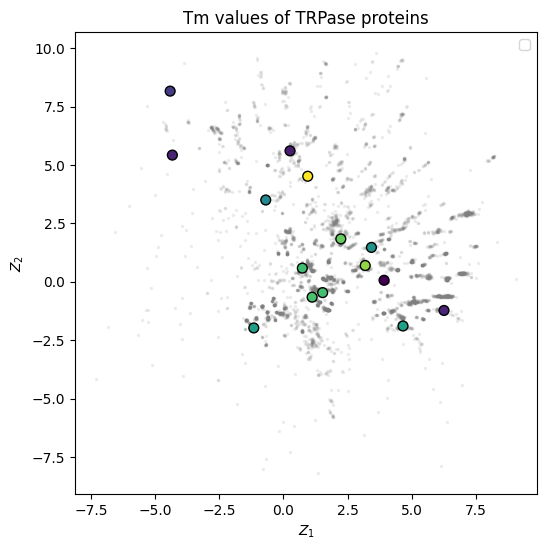

In [10]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(exp_res.iloc[:-5,:].Accession.to_list())

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=50,c=np.array(exp_res.iloc[:-5,:].Tm.to_numpy(),dtype=float),zorder=1)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
ax.set_title('Tm values of TRPase proteins')

if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


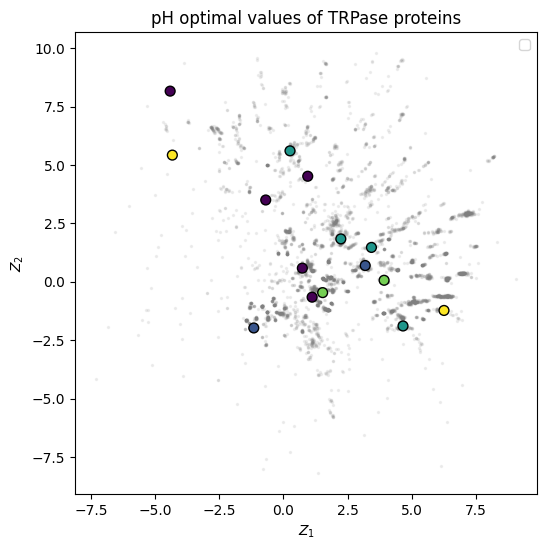

In [11]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(exp_res.iloc[:-5,:].Accession.to_list())

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=50,c=np.array(exp_res.iloc[:-5,:].pH_opt.to_numpy(),dtype=float),zorder=1)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
ax.set_title('pH optimal values of TRPase proteins')

if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


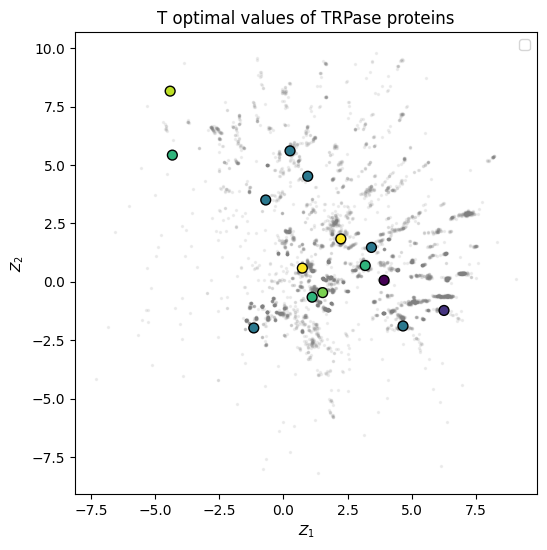

In [12]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(exp_res.iloc[:-5,:].Accession.to_list())

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=50,c=np.array(exp_res.iloc[:-5,:].Topt.to_numpy(),dtype=float),zorder=1)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
ax.set_title('T optimal values of TRPase proteins')

if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


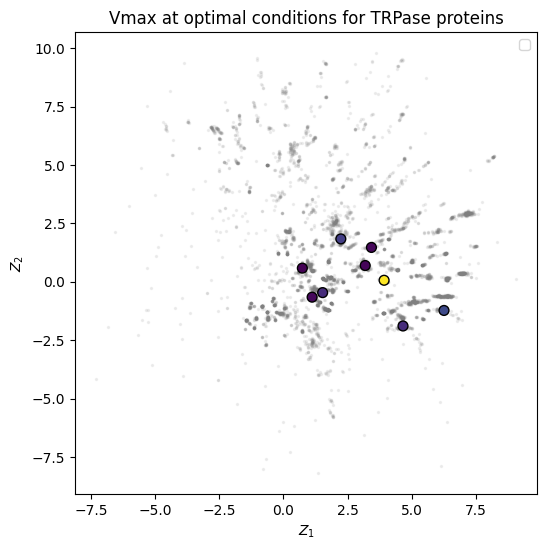

In [13]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(exp_res.iloc[:-5,:].Accession.to_list())

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=50,c=np.array(exp_res.iloc[:-5,:].vmax_opt_mean.to_numpy(),dtype=float),zorder=1)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
ax.set_title('Vmax at optimal conditions for TRPase proteins')


if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


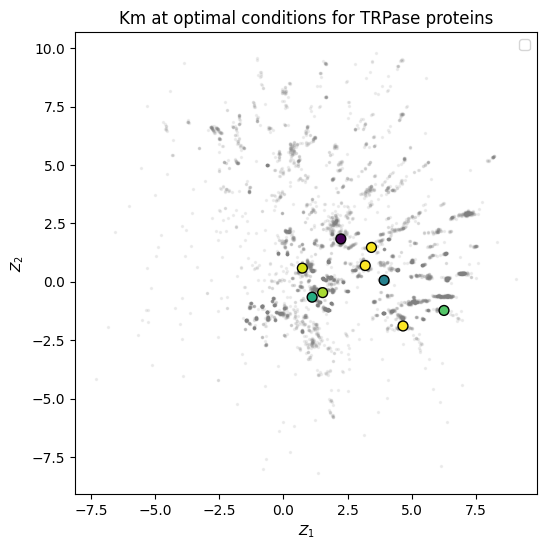

In [14]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(exp_res.iloc[:-5,:].Accession.to_list())

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=50,c=-np.array(exp_res.iloc[:-5,:].Km_opt_mean.to_numpy(),dtype=float),zorder=1,)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
ax.set_title('Km at optimal conditions for TRPase proteins')


if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


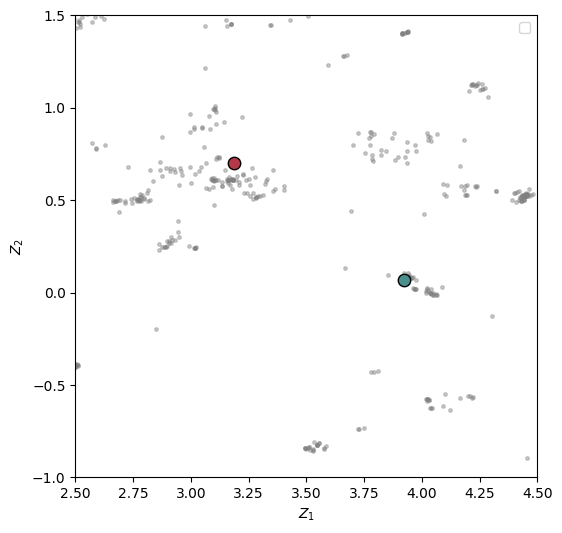

In [15]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


#query_coords = latent_space.key_to_embedding(run.fixed_sequences)
arch_coords = latent_space.key_to_embedding(arch_POI)
euka_coords = latent_space.key_to_embedding(euka_POI)
bact_coords = latent_space.key_to_embedding(bact_POI)

POI_coords = latent_space.key_to_embedding(POI)

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.4, markersize=5, color='grey',zorder=0)
#ax.scatter(arch_coords[0::2], arch_coords[1::2], color='blue',edgecolor='black',s=50,alpha=0.8,label='Archaea')
#ax.scatter(euka_coords[0::2], euka_coords[1::2], color='green',edgecolor='black',s=50,alpha=0.8,label='Eukaryota')
#ax.scatter(bact_coords[0::2], bact_coords[1::2], color='red',edgecolor='black',s=50,alpha=0.8,label='Bacteria')

ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=80,alpha=1,zorder=1)
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=80,alpha=1,zorder=1)

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)

ax.set_xlim(2.5, 4.5)
ax.set_ylim(-1, 1.5)

if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

In [16]:
def decoding(mus, sigmas, samples=500):
    with torch.no_grad():
        mus = torch.tensor(mus.reshape(-1,2)).to(torch.float32)
        sigmas = torch.tensor(sigmas.reshape(-1,2)).to(torch.float32)
        torch.manual_seed(42)
        numerical_sequences = vae.decode_samples(mus, sigmas, samples)
    return numerical_sequences

In [17]:
vae = latent_space.vae

In [18]:
sequences_test = decoding(POI_coords,np.ones_like(POI_coords),samples=500)

In [19]:
def number_to_amino(sequence_list) -> dict:
    """ Transform from number encoding into amino acid alphabet """
    reverse_index = {0: '-'}
    i = 1
    for a in MSA.aa:
        reverse_index[i] = a
        i += 1
    transformed = {}
    # Sequences back to amino acid representation
    for i,seq in enumerate(sequence_list):
        to_amino = seq.tolist()
        amino_seq = [reverse_index[s] for s in to_amino]
        transformed[i] = amino_seq
    return transformed

In [20]:
stacked_seq = None
for i in range(500):
    seq_ = sequences_test[i]
    if stacked_seq is None:
        stacked_seq = seq_
    else:
        stacked_seq = np.vstack((stacked_seq,seq_))

In [21]:
consensus = mode(stacked_seq, axis=0, keepdims=False).mode

In [22]:
consensus_seq = number_to_amino(sequences_test)[0]

In [23]:
POI_seq = ['MKYPAEPFKIKMIEPLRLISREERITALKEAGYNPFSLRAEDVYIDLLTDSGTGAMSDRQWAGLMQGDESYAGSRSFYHLQDSVRDVIGYSYVVPTHQGRGAEQVLFPLLIKPGQSVISNWHFDTTRVHVELAGGKAIDLVTDEALDTNTYHAFKGNIDIEKARKVIEETGKENIALLIITITNNSAGGQPVSMENIKQASALAKEYGLRFLLDAARFSENAYFIKQREAGYQQKSIRQIVREMFTYADAFTMSAKKDGLVNIGGLIGIREKQELYEQIRSAVVPLEGFPTYGGLAGRDMEALAAGLQEVVEEEYLHYRIAQIAYLGDRLVAGGIPIQTPTGGHAVFVDAKKMLSHIPFDQFPGQVLANELYVESGVRAVEVGSLLLGRDPKTNQQLVSPLELLRLTIPRRVYTYAHMDVIADGLIRIKERAHELRGLTFTYEPPMLRHFTARLKPVEEK',
            'MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYIDLLTDSGTNAMSDHQWAAMITGDEAYAGSRNYYDLKDKAKELFNYDYIIPAHQGRGAENILFPVLLKYKQKEGKAKNPVFISNFHFDTTAAHVELNGCKAINIVTEKAFDSETYDDWKGDFDIKKLKENIAQHGADNIVAIVSTVTCNSAGGQPVSMSNLKEVYEIAKQHGIFVVMDSARFCENAYFIKERDPKYKNATIKEVIFDMYKYADALTMSAKKDPLLNIGGLVAIRDNEEIFTLARQRCVPMEGFVTYGGLAGRDMAAMVQGLEEGTEEEYLHYRIGQVKYLGDRLREAGIPIQYPTGGHAVFVDCKKLVPQIPGDQFPAQAVINALYLESGVRAVEIGSFLLGRDPATGEQKHADMEFMRLTIARRVYTNDHMDYIADALIGLKEKFATLKGLEFEYEPPVLRHFTARLKPIE'
            ]

In [24]:
def find_missing_positions(true_seq, msa_seq):
    missing_positions = []
    true_index = 0
    msa_index = 0
    
    while true_index < len(true_seq) and msa_index < len(msa_seq):
        if msa_seq[msa_index] == '-':
            # Skip gap in the MSA
            msa_index += 1
        elif true_seq[true_index] != msa_seq[msa_index]:
            # Mismatch or missing residue
            missing_positions.append((true_index, true_seq[true_index]))
            true_index += 1
        else:
            # Match
            true_index += 1
            msa_index += 1
    
    # If there’s anything left in the true sequence after the MSA ends
    if true_index < len(true_seq):
        for i in range(true_index, len(true_seq)):
            missing_positions.append((i, true_seq[i]))
    
    return missing_positions

def insert_missing_amino_acids(msa_seq, missing_positions):
    # Convert to list for easy insertion
    msa_list = list(msa_seq)
    
    for pos, residue in sorted(missing_positions):
        if pos <= len(msa_list):
            msa_list.insert(pos, residue)
        else:
            # If the position is out of bounds, append to the end
            msa_list.append(residue)
    
    # Convert back to string
    return ''.join(msa_list)



In [25]:
msa = MSA.load_msa(run.dataset)
decoded_seqs = []
for i in range(2):
    print('Using template sequence:', POI[i])
    msa_seq_ = ''.join([msa[POI[i]][s] for s in msa_columns])
    missing_positions = find_missing_positions(POI_seq[i], msa_seq_)
    print("Missing positions:", missing_positions)
    decoded_template = insert_missing_amino_acids(consensus_seq, missing_positions)
    decoded_seqs.append(decoded_template)
    print(decoded_template)
    print()

Using template sequence: WP_104148942.1
Missing positions: [(272, 'Q'), (456, 'V'), (457, 'E'), (458, 'E'), (459, 'K')]
MRRIPEPFRIKMVEPIKMTTREEREQRLAEAGYNLFSLKAEDVYIDLLTDSGTGAMSDGQWAGVMMGDEAYAGSRSYFKLVDTVKEIFGYKYIQPVHQGRAAEKVLFPLLVKKGKVAISNMHFDTTKAHVELAGARAINCVVPEALDTTKPAPFKGNMDVARLESLIAEHGADNVAAVIITVTCNSAGGQPVSMANMREVSALAKKHGIPVVIDAARFAENAYFIKQREPGYADKSIKEIVREMFSYGDMFTMSAKKDAIVNIGGLLGVKDDQELFQNVQVRCISFEGFVTYGGLAGRDLEALAIGLREGIDEDYLRYRIGQVEYLAARLDEAGIAYQSPTGGHAVFVDAKKLLPHIPYNQFPAQALAIELYLEAGIRSCEIGSYLLGNDPDTGEQEQADFELTRLAIPRRVYTQDHMDYIADALIAIKERASEIRGYRITWEPPILRHFTARLKPVEEK

Using template sequence: WP_129037438.1
Missing positions: [(0, 'M'), (113, 'Y'), (115, 'Q'), (116, 'K'), (117, 'E'), (118, 'G'), (119, 'K'), (120, 'A'), (121, 'K'), (282, 'E'), (465, 'I'), (466, 'E')]
MMRRIPEPFRIKMVEPIKMTTREEREQRLAEAGYNLFSLKAEDVYIDLLTDSGTGAMSDGQWAGVMMGDEAYAGSRSYFKLVDTVKEIFGYKYIQPVHQGRAAEKVLFPLLVKYKQKEGKAKGKVAISNMHFDTTKAHVELAGARAINCVVPEALDTTKPAPFKGNMDVARLESLIAEHGADNVAAVIITVTCNSAGGQPVSMANMREVSALAKKH

In [26]:
msa_seqs = []
for i in range(2):
    msa_seq_ = ''.join([msa[POI[i]][s] for s in msa_columns])
    msa_seqs.append(msa_seq_)

In [27]:
import random

def identify_mutations(seq1, seq2):
    mutations = []
    for i, (res1, res2) in enumerate(zip(seq1, seq2)):
        if res1 != res2:
            mutations.append((i, res1, res2))  # (position, original, target)
    return mutations

def apply_mutation(seq, mutation):
    index, _, new_res = mutation
    seq = list(seq)
    seq[index] = new_res
    return ''.join(seq)

def random_walk_mutation(start_seq, target_seq, max_steps=1000, num_walks=1, seed=42):
    # Set the random seed for reproducibility
    random.seed(seed)
    
    all_walks = []  # To store results from all walks
    all_sequences = []  # To store all generated sequences across walks

    for walk in range(num_walks):
        mutations = identify_mutations(start_seq, target_seq)
        current_seq = start_seq
        mutation_path = []
        walk_sequences = [start_seq]
        
        for step in range(max_steps):
            if current_seq == target_seq:
                break
            
            # Pick a random mutation from the remaining pool
            mutation = random.choice(mutations)
            current_seq = apply_mutation(current_seq, mutation)
            mutation_path.append(mutation)
            walk_sequences.append(current_seq)
            
            # Remove applied mutation from the pool
            mutations.remove(mutation)
        
        # Save the results of this walk
        all_walks.append({
            "final_sequence": current_seq,
            "mutation_path": mutation_path,
            "sequences": walk_sequences
        })
        all_sequences.extend(walk_sequences)
    
    # Encode all sequences in one batch
    mu,_ = latent_space.encode(all_sequences)
    
    # Assign latent coordinates back to the walk data
    idx = 0
    for walk in all_walks:
        walk['latent_coords'] = mu[idx: idx + len(walk['sequences'])]
        idx += len(walk['sequences'])
    
    return all_walks, mu

In [28]:
all_walks, all_latent_coords = random_walk_mutation(msa_seqs[1], msa_seqs[0],num_walks=1000)

In [29]:
all_sequences = [all_walks[s]['sequences'] for s in range(len(all_walks))]
all_sequences = np.array(all_sequences).reshape(-1)

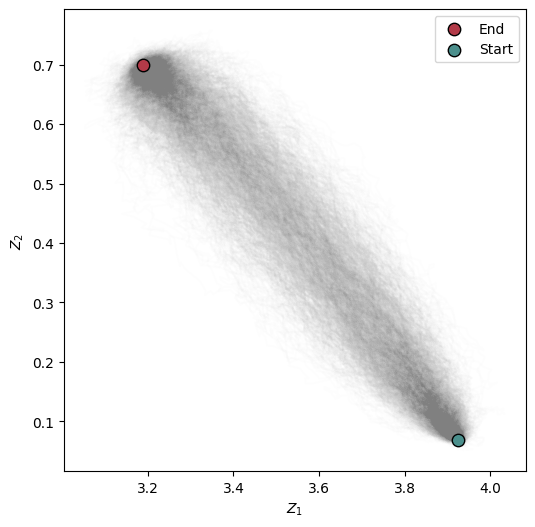

In [30]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


POI_coords = latent_space.key_to_embedding(POI)

fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))

for walk in all_walks:
    ax.plot(walk['latent_coords'][:, 0], walk['latent_coords'][:, 1], '-', alpha=0.01, color='grey',zorder=0)
    #ax.plot(walk['latent_coords'][:, 0], walk['latent_coords'][:, 1], '-', alpha=0.1, color='grey',zorder=0)

ax.scatter(POI_coords[0::2][0], POI_coords[1::2][0], color='#B23A48',edgecolor='black',s=80,alpha=1,zorder=1,label='End')
ax.scatter(POI_coords[0::2][1], POI_coords[1::2][1], color='#4B8F8C',edgecolor='black',s=80,alpha=1,zorder=1,label='Start')

# Project 
ax.legend()
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)

#ax.set_xlim(2, 5)
#ax.set_ylim(-2, 2)


In [31]:
# Example latent points (replace with your actual latent coords)
latent_points = np.array([list(z) for z in all_latent_coords])

# Fit KernelDensity
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')  # bandwidth controls smoothness
kde.fit(latent_points)

KernelDensity(bandwidth=0.02)

In [32]:
# Create a grid over the plot area
x = np.linspace(3.0, 4.0, 200)
y = np.linspace(0.0, 0.8, 200)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE over the grid
Z = kde.score_samples(grid_points)
Z = np.exp(Z).reshape(X.shape)  # Convert log density to actual density


In [33]:
# Invert density to use as a cost map (high density = low cost)
cost_map = 1 / (Z + 1e-10)

# Find shortest path using A* through the highest density
start = np.unravel_index(np.argmin(np.sum((grid_points - latent_points[0])**2, axis=1)), X.shape)
end = np.unravel_index(np.argmin(np.sum((grid_points - latent_points[-1])**2, axis=1)), X.shape)
path, _ = route_through_array(cost_map, start, end, fully_connected=True)

# Convert path to coordinates
path_coords = np.array([(X[i, j], Y[i, j]) for i, j in path])

In [34]:
tree = cKDTree(latent_points)
distances_path, indices_path = tree.query(path_coords)

# Get sequences along the path
path_sequences = [all_sequences[idx] for idx in indices_path]
path_coords_true = np.array([all_latent_coords[idx].tolist() for idx in indices_path])


In [35]:
Z_start = latent_points[0]
Z_end = latent_points[-1]

# Step 1: Interpolate quartile points between Z_start and Z_end
Z_25 = Z_start + 0.25 * (Z_end - Z_start)
Z_50 = Z_start + 0.50 * (Z_end - Z_start)
Z_75 = Z_start + 0.75 * (Z_end - Z_start)
quartile_points = np.array([Z_25, Z_50, Z_75])

# Store indices of closest black dots
closest_indices_per_quartile = []

for zp in quartile_points:
    distances = np.linalg.norm(path_coords_true - zp, axis=1)
    closest_indices = np.argsort(distances)[:5]
    closest_indices_per_quartile.append(closest_indices)

# Optional: get coordinates and sequences
closest_coords_per_quartile = [path_coords_true[idxs] for idxs in closest_indices_per_quartile]
sequences_per_quartile = [[all_sequences[i] for i in idxs] for idxs in closest_indices_per_quartile]


In [36]:
import matplotlib.cm as cm

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_7006/2565830912.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.


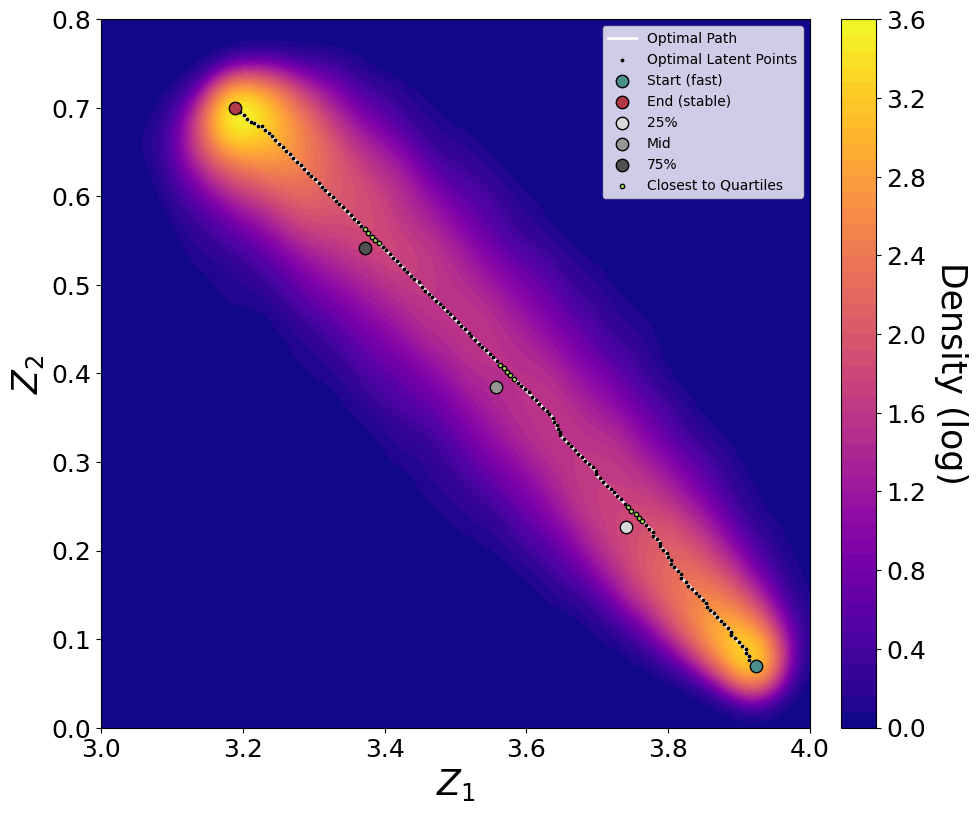

In [37]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='plasma',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(latent_points[0, 0], latent_points[0, 1], color='#4B8F8C', s=80, label="Start (fast)", edgecolors='black', zorder=3)
ax.scatter(latent_points[-1, 0], latent_points[-1, 1], color='#B23A48', s=80, label="End (stable)", edgecolors='black', zorder=3)

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [38]:
decoded_seqs = {}
print('Using template sequence:', POI[1])
msa_seq_ = ''.join([msa[POI[1]][s] for s in msa_columns])
missing_positions = find_missing_positions(POI_seq[1], msa_seq_)
print("Missing positions:", missing_positions)
for i,quartile in enumerate([25, 50, 75]):
    dec_seq_ = []
    for seq in sequences_per_quartile[i]:
        decoded_template = insert_missing_amino_acids(seq, missing_positions)
        dec_seq_.append(decoded_template)
    decoded_seqs[quartile] = dec_seq_

Using template sequence: WP_129037438.1
Missing positions: [(0, 'M'), (113, 'Y'), (115, 'Q'), (116, 'K'), (117, 'E'), (118, 'G'), (119, 'K'), (120, 'A'), (121, 'K'), (282, 'E'), (465, 'I'), (466, 'E')]


In [39]:

with open(run.result+'/closest_quartile_sequences.fasta', 'w') as output_file:
    for quartile, seqs in decoded_seqs.items():
        for i,seq in enumerate(seqs):
            output_file.write(f">Quartile_{quartile}_{i}\n")
            output_file.write(f"{seq}\n")

for quartile, seqs in decoded_seqs.items():
    for i,seq in enumerate(seqs):
        with open(run.result+f'/closest_quartile_sequences_{quartile}_{i}.fasta', 'w') as output:
            output.write(f">Quartile_{quartile}_{i}\n")
            output.write(f"{seq}\n")



/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_7006/1274979010.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.


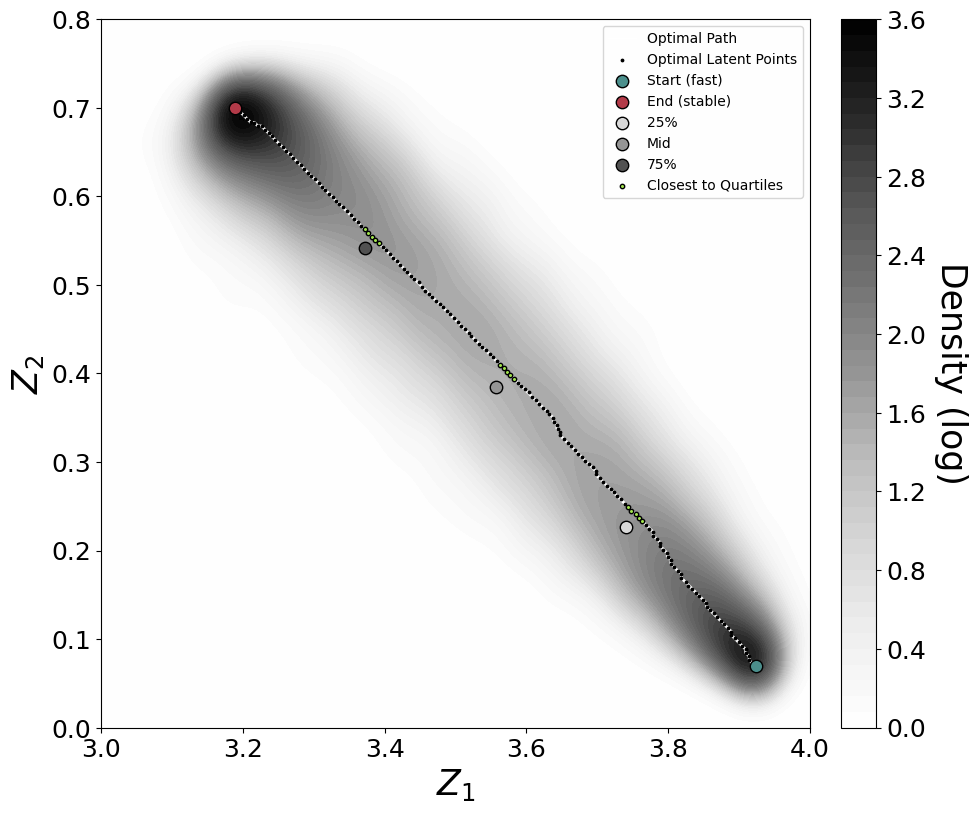

In [40]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='Greys',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(latent_points[0, 0], latent_points[0, 1], color='#4B8F8C', s=80, label="Start (fast)", edgecolors='black', zorder=3)
ax.scatter(latent_points[-1, 0], latent_points[-1, 1], color='#B23A48', s=80, label="End (stable)", edgecolors='black', zorder=3)

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_7006/1730344438.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.


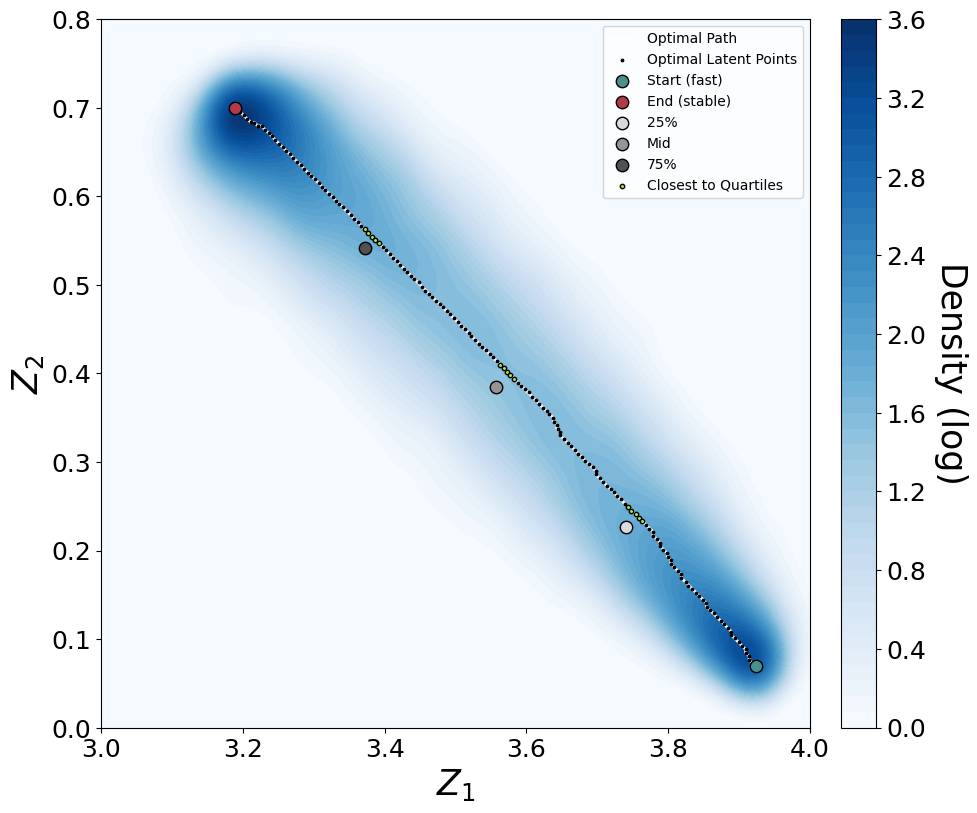

In [41]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='Blues',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(latent_points[0, 0], latent_points[0, 1], color='#4B8F8C', s=80, label="Start (fast)", edgecolors='black', zorder=3)
ax.scatter(latent_points[-1, 0], latent_points[-1, 1], color='#B23A48', s=80, label="End (stable)", edgecolors='black', zorder=3)

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_7006/3746205062.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.


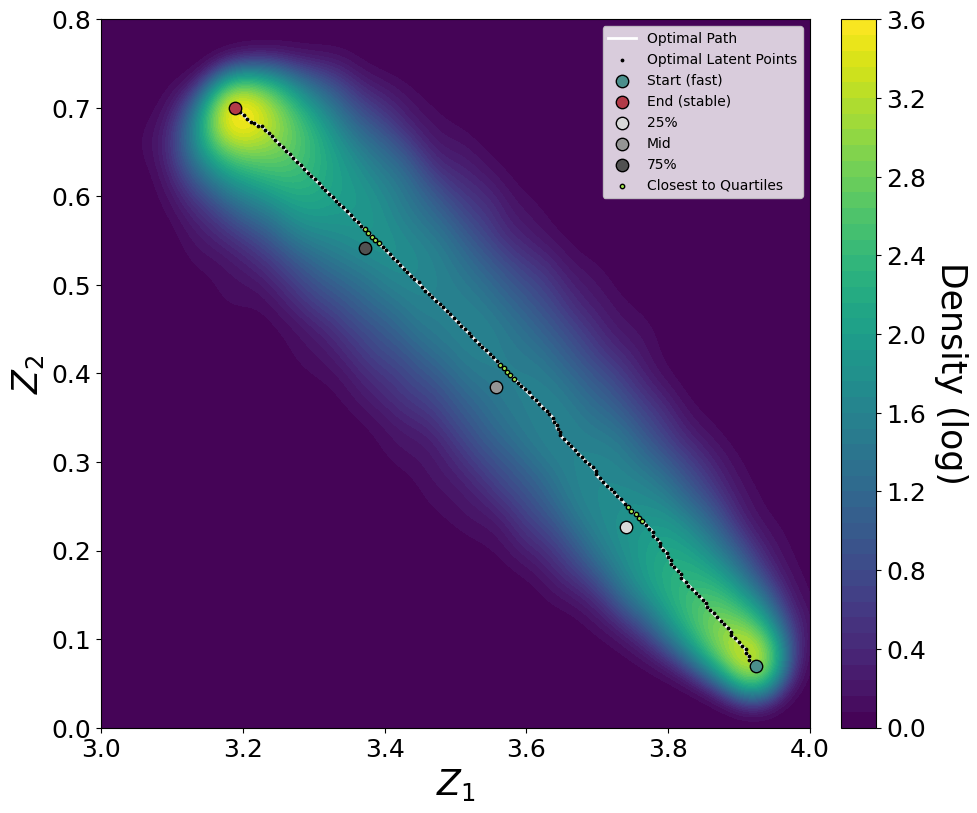

In [42]:
# Plot KDE and path
fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

density_map = ax.contourf(X, Y, np.log1p(Z), levels=50, cmap='viridis',zorder=0)
cb = fig_lat.colorbar(density_map,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('Density (log)',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Plot the path
ax.plot(path_coords[:, 0], path_coords[:, 1], color='white', linewidth=2, label="Optimal Path", zorder=1)

# Plot the latent points
ax.scatter(path_coords_true[:, 0], path_coords_true[:, 1], s=3, color='black', alpha=1, label="Optimal Latent Points", zorder=2)

# Mark start and end points
ax.scatter(latent_points[0, 0], latent_points[0, 1], color='#4B8F8C', s=80, label="Start (fast)", edgecolors='black', zorder=3)
ax.scatter(latent_points[-1, 0], latent_points[-1, 1], color='#B23A48', s=80, label="End (stable)", edgecolors='black', zorder=3)

# Mark quartile points
# Choose a colormap
cmap = cm.get_cmap('Greys')  # or 'viridis', 'coolwarm', 'magma', etc.

# Pick 3 points along the gradient (normalized 0-1 scale)
colors = [cmap(0.25), cmap(0.5), cmap(0.75)]
ax.scatter(Z_25[0], Z_25[1], color=colors[0], s=80, label="25%", edgecolors='black', zorder=3)
ax.scatter(Z_50[0], Z_50[1], color=colors[1], s=80, label="Mid", edgecolors='black', zorder=3)
ax.scatter(Z_75[0], Z_75[1], color=colors[2], s=80, label="75%", edgecolors='black', zorder=3)

# Closest points to quartiles
for i, (coords, seqs) in enumerate(zip(closest_coords_per_quartile, sequences_per_quartile)):
    for j, (coord, seq) in enumerate(zip(coords, seqs)):
        if j == 0 and i == 0:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, label=f"Closest to Quartiles", alpha=1)
        else:
            ax.scatter(coord[0], coord[1], s=10, color='#A1E44D', edgecolors='black', zorder=4, alpha=1)

# Label axes
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [43]:
seq_selection_netsolp = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPase_VAEselection_NetSolP.csv',index_col=0)
seq_selection_netsolp = seq_selection_netsolp[['fasta','predicted_solubility','predicted_usability']]
seq_selection_soluprot = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/TRPase/TRPase_VAEselection_SoluProt.csv',index_col=0)
seq_

tensor([17,  3, 19, 15, 12,  5, 12, 19,  1, 15,  1, 14, 14,  5, 12, 15,  1,  3,
         7,  7,  1,  5,  5,  1,  5,  5, 13, 16,  3,  5,  6, 11, 19,  8, 12, 18,
        16, 16,  4,  6,  6,  4, 14, 18, 15,  4, 16, 16,  7,  4,  6, 11,  7, 11,
         6, 14,  7,  9, 11, 17,  9, 13, 13, 17, 16,  3, 11,  4,  5, 13, 19,  6,
        11,  6,  1,  6, 19, 19, 14, 16,  3,  4, 13, 14,  5,  4, 15, 18, 11, 19,
         1, 16,  7, 15, 12,  7,  2,  9, 11,  1, 11, 13,  5,  9, 16, 19, 14, 12,
        13, 16, 15, 13,  9,  3, 17, 13, 13, 15,  6,  8, 18, 18, 18,  4,  7,  7,
         9, 11,  2,  6,  9, 15,  8, 11, 10,  3, 15, 14,  8, 14, 12,  7,  5,  5,
        13, 18,  4,  7,  6, 14,  5, 13,  4, 18,  3, 11,  8, 18,  4, 15,  4,  3,
        16, 15, 15,  7, 15,  5,  4, 15, 11, 13,  3,  8, 14, 12, 19, 15, 14,  6,
         7, 15,  7, 10,  8,  6, 13, 11, 11,  9, 12, 14,  6, 14, 13,  8, 16,  3,
         5, 14, 19,  5, 15, 13,  9,  2, 19,  4, 15, 12, 14, 14, 17,  4, 10, 13,
         1, 18, 13,  5,  8, 13, 19, 18, 

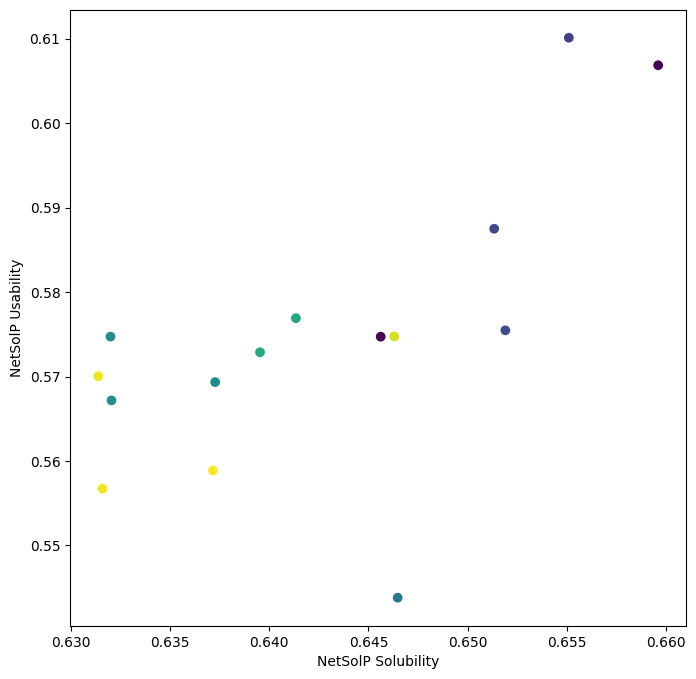

In [44]:
fig, ax = plt.subplots(1, 1,figsize=(8,8))


ax.scatter(seq_selection_netsolp.predicted_solubility,seq_selection_netsolp.predicted_usability,c=seq_selection_soluprot.soluble)
ax.set_xlabel('NetSolP Solubility')
ax.set_ylabel('NetSolP Usability')
ax.set_box_aspect(1)
plt.show()


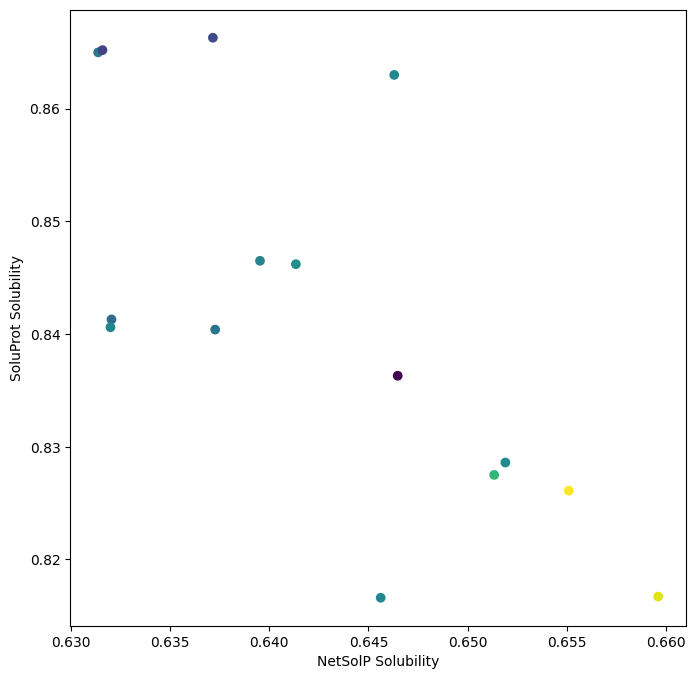

In [45]:
fig, ax = plt.subplots(1, 1,figsize=(8,8))


ax.scatter(seq_selection_netsolp.predicted_solubility,seq_selection_soluprot.soluble,c=seq_selection_netsolp.predicted_usability)
ax.set_xlabel('NetSolP Solubility')
ax.set_ylabel('SoluProt Solubility')
ax.set_box_aspect(1)
plt.show()